In [92]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

mpl.rcParams["axes.unicode_minus"]=False

import warnings
warnings.filterwarnings('ignore')

In [93]:
train=pd.read_csv('https://raw.githubusercontent.com/sun8338/Bike-Sharing-Demand/main/train.csv', parse_dates=["datetime"])
train.shape

(10886, 12)

In [94]:
test=pd.read_csv('https://raw.githubusercontent.com/sun8338/Bike-Sharing-Demand/main/test.csv', parse_dates=["datetime"])
test.shape

(6493, 9)

In [95]:
train["year"]=train["datetime"].dt.year
train["month"]=train["datetime"].dt.month
train["day"]=train["datetime"].dt.day
train["hour"]=train["datetime"].dt.hour
train["minute"]=train["datetime"].dt.minute
train["second"]=train["datetime"].dt.second
train["dayofweek"]=train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [96]:
test["year"]=test["datetime"].dt.year
test["month"]=test["datetime"].dt.month
test["day"]=test["datetime"].dt.day
test["hour"]=test["datetime"].dt.hour
test["minute"]=test["datetime"].dt.minute
test["second"]=test["datetime"].dt.second
test["dayofweek"]=test["datetime"].dt.dayofweek
test.shape

(6493, 16)

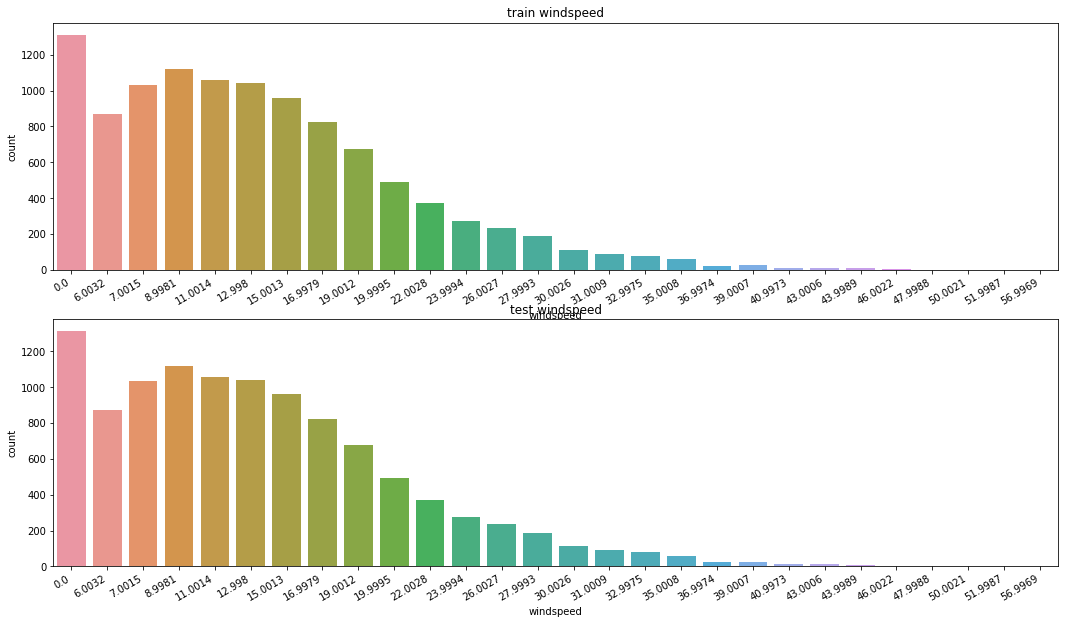

In [97]:
fig, axes=plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count', title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count', title="test windspeed")
sns.countplot(data=train, x="windspeed", ax=axes[1])

In [98]:
trainWind0=train.loc[train["windspeed"]==0]
trainWindNOt0=train.loc[train["windspeed"]!=0]
print(trainWind0.shape)
print(trainWindNOt0.shape)

(1313, 19)
(9573, 19)


In [99]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    dataWind0=data.loc[data['windspeed']==0]
    dataWindNOt0=data.loc[data['windspeed']!=0]

    wCol=["season", "weather", "humidity", "month", "temp", "year", "atemp"]
    dataWindNOt0["windspeed"]=dataWindNOt0["windspeed"].astype("str")
    rfModel_wind=RandomForestClassifier()
    rfModel_wind.fit(dataWindNOt0[wCol], dataWindNOt0["windspeed"])
    wind0Values=rfModel_wind.predict(X=dataWind0[wCol])

    predictWind0=dataWind0
    predictWindNot0=dataWindNOt0

    predictWind0["windspeed"]=wind0Values
    data=predictWindNot0.append(predictWind0)
    data["windspeed"]=data["windspeed"].astype("float")

    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)

    return data

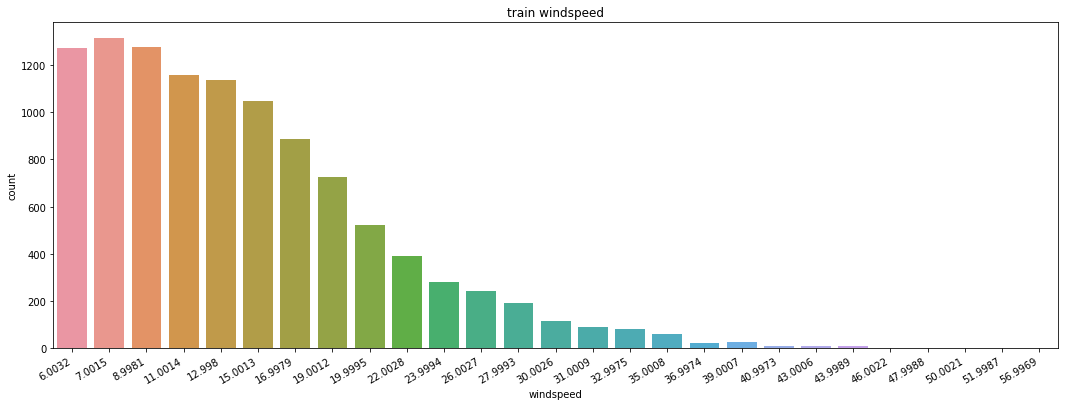

In [100]:
train=predict_windspeed(train)
fig, ax1=plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count', title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1)

In [101]:
categorical_feature_names=["season", "holiday", "workingday", "weather", "dayofweek", "month", "year", "hour"]

for var in categorical_feature_names:
    train[var]=train[var].astype("category")
    test[var]=test[var].astype("category")

In [102]:
feature_names=["season", "weather", "temp", "atemp", "humidity", "windspeed", "year", "hour", "dayofweek", "holiday", "workingday"]
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [103]:
X_train=train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [104]:
X_test=test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 11)


,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [105]:
label_name="count"

y_train=train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

In [106]:
from numpy.lib.npyio import savez_compressed
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    predicted_values=np.array(predicted_values)
    actual_values=np.array(actual_values)

    log_predict=np.log(predicted_values +1)
    log_actual=np.log(actual_values +1)

    difference=log_predict-log_actual 
    difference=np.square(difference)

    mean_difference=difference.mean()
    score=np.sqrt(mean_difference)

    return score

rmsle_scorer=make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [107]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold=KFold(n_splits=10, shuffle=True, random_state=0)

In [108]:
from sklearn.ensemble import RandomForestRegressor

max_depth_list=[]
model=RandomForestRegressor(n_estimators=300,
                            n_jobs=-1,
                            random_state=0)
model

RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=0)

In [109]:
%time score=cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score=score.mean()

print("Score={0:.5f}".format(score))

CPU times: user 10.6 s, sys: 1.92 s, total: 12.5 s
Wall time: 1min 17s
Score=0.32927


In [110]:
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=0)

In [111]:
predictions=model.predict(X_test)

print(predictions.shape)
predictions[0:10]

(6493,)


array([ 12.11      ,   4.98333333,   4.04833333,   3.415     ,
         3.03      ,   6.51333333,  38.43666667, 106.39333333,
       238.92333333, 138.06      ])

[Text(0.5, 1.0, 'test')]

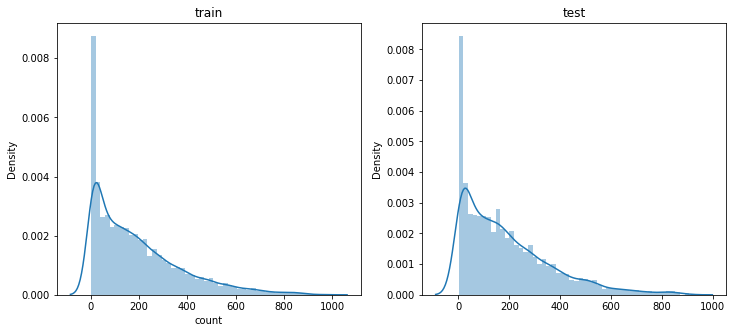

In [112]:
fig, (ax1, ax2)=plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sns.distplot(y_train, ax=ax1, bins=50)
ax1.set(title="train")
sns.distplot(predictions, ax=ax2, bins=50)
ax2.set(title="test")

In [113]:
submission=pd.read_csv("https://raw.githubusercontent.com/sun8338/Bike-Sharing-Demand/main/sampleSubmission.csv")
submission

submission["count"]=predictions

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,12.110000
1,2011-01-20 01:00:00,4.983333
2,2011-01-20 02:00:00,4.048333
3,2011-01-20 03:00:00,3.415000
4,2011-01-20 04:00:00,3.030000


In [114]:
submission.to_csv("Score_{0:.5f}_submission.cvs".format(score), index=False)